In [89]:
from random import random, randint
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import math
from time import sleep

import numpy.random


class Robot:
    def __init__(self, π_zc = 1, π_zm = 1, π_wm = 1, k = 0.3, speed = 0.01, static = False, gradient = False, periodic = False, upd_c = True, upd_m = True):
        self.sensor_colour = 0 # sensor colour
        self.static_sensor_colour = static # bool to check if sensor is static
        self.gradient_sensor_colour = gradient # bool for gradient
        self.periodic_sensor_colour = periodic
        self.sensor_motor = 0 # sensor motor

        self.belief_colour = 0 # μ colour
        self.update_belief_c = upd_c
        self.belief_motor = 0 # μ motor
        self.update_belief_m = upd_m

        self.pi_z_colour = π_zc # inverse of variance - whatever
        self.pi_z_motor = π_zm # inverse of variance - whatever
        self.pi_w_motor = π_wm # inverse of variance - whatever

        self.k = k # factor k
        self.a = 0 # speed
        self.speed = speed # speed scaling factor

        self.position = 0 # position of robot
        self.free_energy = 0 # F

        # Save for plot
        self.positions = []
        self.free_energies = []
        self.sensor_readings_colour = []
        self.beliefs_colour = []
        self.sensor_readings_motor = []
        self.beliefs_motor = []

    '''
    Main function to simulate one step per call
    '''
    # -- Do one step -- #
    def step(self):
        self.update()
        self.move()
        self.log_data()

    '''
    Updating all values
    '''
    # -- Update step -- #
    def update(self):
        self.update_sensor()
        self.update_belief()
        self.update_a()
        self.update_F()
    # -- Update sensor reading, beliefs, a (speed) and F (free energy) -- #
    def update_sensor(self):
        if self.static_sensor_colour:
            self.sensor_colour = 1
        elif self.gradient_sensor_colour:
            self.sensor_colour = 10 - self.position
        elif self.periodic_sensor_colour:
            self.sensor_colour = math.cos(self.position) + 1.1
        else:
            self.sensor_colour = self.belief_colour #+ numpy.random.normal(0, 1)


        self.sensor_motor = self.a #+ numpy.random.normal(0, 1)
    def update_belief(self):
        old_belief_c = self.belief_colour
        old_belief_m = self.belief_motor
        if self.update_belief_c:
            self.belief_colour += (-self.k) * ((self.pi_z_colour * (old_belief_c - self.sensor_colour)) + (self.pi_w_motor * (old_belief_c - old_belief_m)))
        if self.update_belief_m:
            self.belief_motor += (-self.k) * ((self.pi_z_motor * (old_belief_m - self.sensor_motor)) + (self.pi_w_motor * (old_belief_m - old_belief_c)))
    def update_a(self):
        self.a += (-self.k) * (self.pi_z_motor * (self.sensor_motor - self.belief_motor))
    def update_F(self):
        self.free_energy = 1/2 * ((self.pi_z_colour * math.pow((self.sensor_colour - self.belief_colour), 2)) + self.pi_z_motor * math.pow((self.sensor_motor - self.belief_motor), 2) + self.pi_w_motor * math.pow((self.belief_motor - self.belief_colour), 2))

    '''
    Move - just a update position function
    '''
    def move(self):
        self.position += self.speed * self.a

    '''
    Log Position, F, Sensor colour and belief motor
    '''
    def log_data(self):
        #print(f"Robot is at position: {self.position} with free energy: {self.free_energy} and sensor_c: {self.sensor_colour} with μ_c: {self.belief_colour} and sensor_m: {self.sensor_motor} with μ_m: {self.belief_motor}")
        self.positions.append(self.position)
        self.free_energies.append(self.free_energy)
        self.sensor_readings_colour.append(self.sensor_colour)
        self.beliefs_colour.append(self.belief_colour)
        self.sensor_readings_motor.append(self.sensor_motor)
        self.beliefs_motor.append(self.belief_motor)

    def line_plot(self):
        fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

        # Plot Position and Free Energy
        axs[0].plot(self.positions, label='Position', color='blue')
        axs[0].set_ylabel('Position')
        axs[0].legend(loc='upper left')
        ax2 = axs[0].twinx()
        ax2.plot(self.free_energies, label='Free Energy', color='red', linestyle='--')
        ax2.set_ylabel('Free Energy')
        ax2.legend(loc='upper right')
        axs[0].set_title('Position and Free Energy over Time')

        # Plot Sensor Colour and Belief Colour
        axs[1].plot(self.sensor_readings_colour, label='Sensor Colour', color='green')
        axs[1].plot(self.beliefs_colour, label='Belief Colour (μ_c)', color='orange')
        axs[1].set_ylabel('Colour Values')
        axs[1].legend()
        axs[1].set_title('Sensor and Belief (Colour) over Time')

        # Plot Sensor Motor and Belief Motor
        axs[2].plot(self.sensor_readings_motor, label='Sensor Motor', color='purple')
        axs[2].plot(self.beliefs_motor, label='Belief Motor (μ_m)', color='brown')
        axs[2].set_ylabel('Motor Values')
        axs[2].set_xlabel('Timestep')
        axs[2].legend()
        axs[2].set_title('Sensor and Belief (Motor) over Time')

        plt.tight_layout()
        plt.show()






In [90]:
for i in range(1):
    robot = Robot(gradient = True)
    for E in range(6000):
        robot.step()

In [91]:
# 3.1
robot1 = Robot(static=True)
robot2 = Robot(gradient=True)
robot3 = Robot(periodic=True)
for i in range(6000):
    robot1.step()
    robot2.step()
    robot3.step()


## 3.1 k = 0.3 ; π_zc = π_zm = π_wm = 1 ; the standard case
### First we see the line plots for static: c = 1
The beliefs can be updated here so µ_m and µ_c will converge to 1 rather fast which is optimal for the free energy (converges to 0).

Still will happen rather fast since sensor_c stays at 1.

The movement will be quite linear since after convergence it will be a constant movement (a).

### Next for gradient: c = 10 - x
The robot moves in this case which will result in the sensor c gradually getting smaller and converging to 0 which will result in µ_m and µ_c to converge to 0 as well.

Therefore a (speed) will be 0 at that point as well. So when the position hits 10 the speed (a), µ_m, µ_c, sensor_colour and sensor_motor will all be 0

### Then for periodic: c = cos(x) + 1.1
The robot moves forward but since sensor_colour depends on the position it will oscillate. So first sensor_colour gets smaller, then at 0.1 (minimum c value) it will start going towards 2.1 again and then at 2.1 back to 0.1 and so on.

This will result in µ_m, µ_c and sensor_motor oscillating as well. The free energy will be near 0 since sensor_colour, sensor_motor, µ_m and µ_c are oscillating together.

The speed (a) is influenced as well which results in the robot accelerating and decelerating in accordance with the cos-function.

---------------------------------------------------------------------------------------------------------------------
Line plots for robot with static c = 1 and for standard case


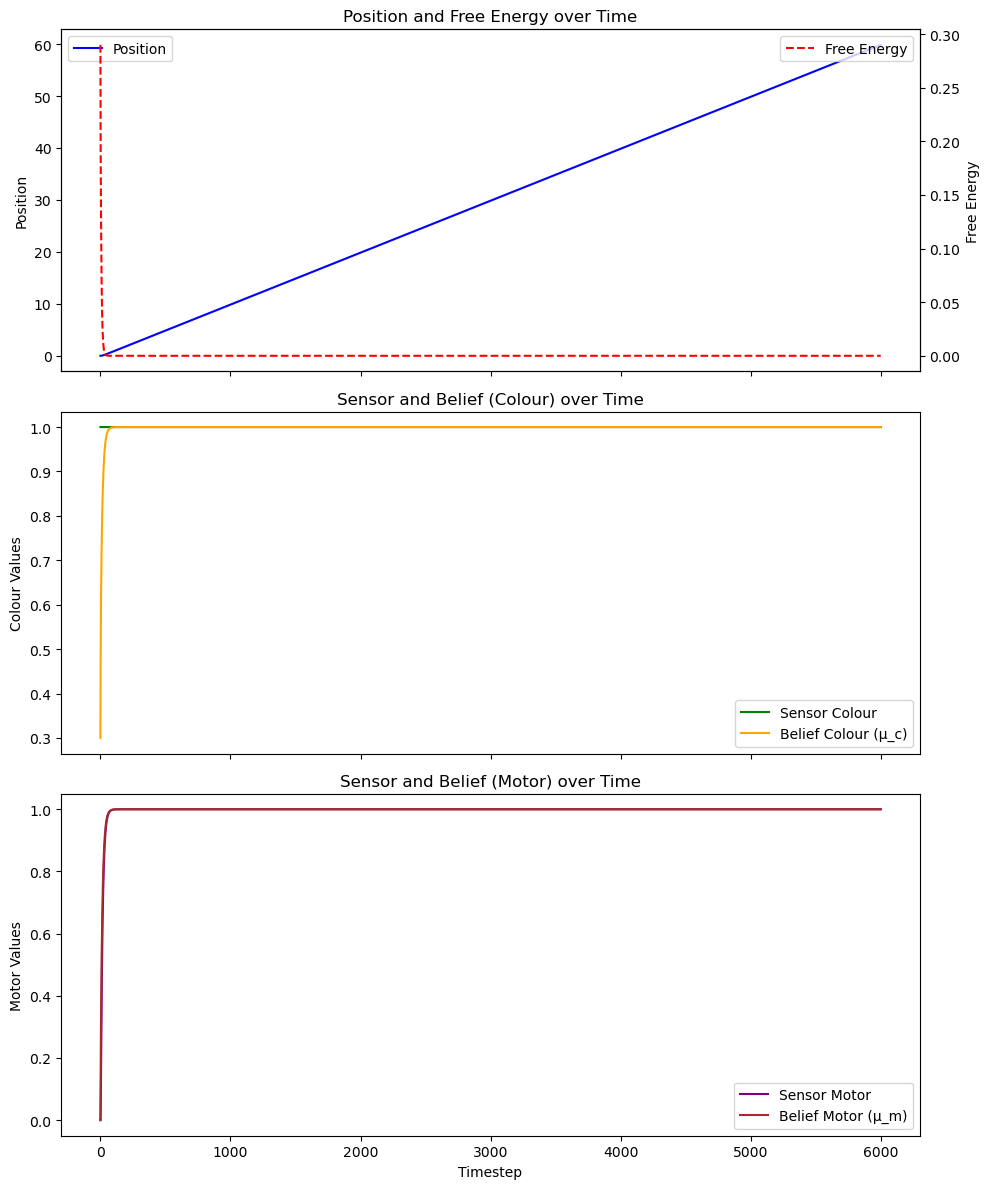

---------------------------------------------------------------------------------------------------------------------
Line plots for robot with gradient c update: 10 - x and for standard case


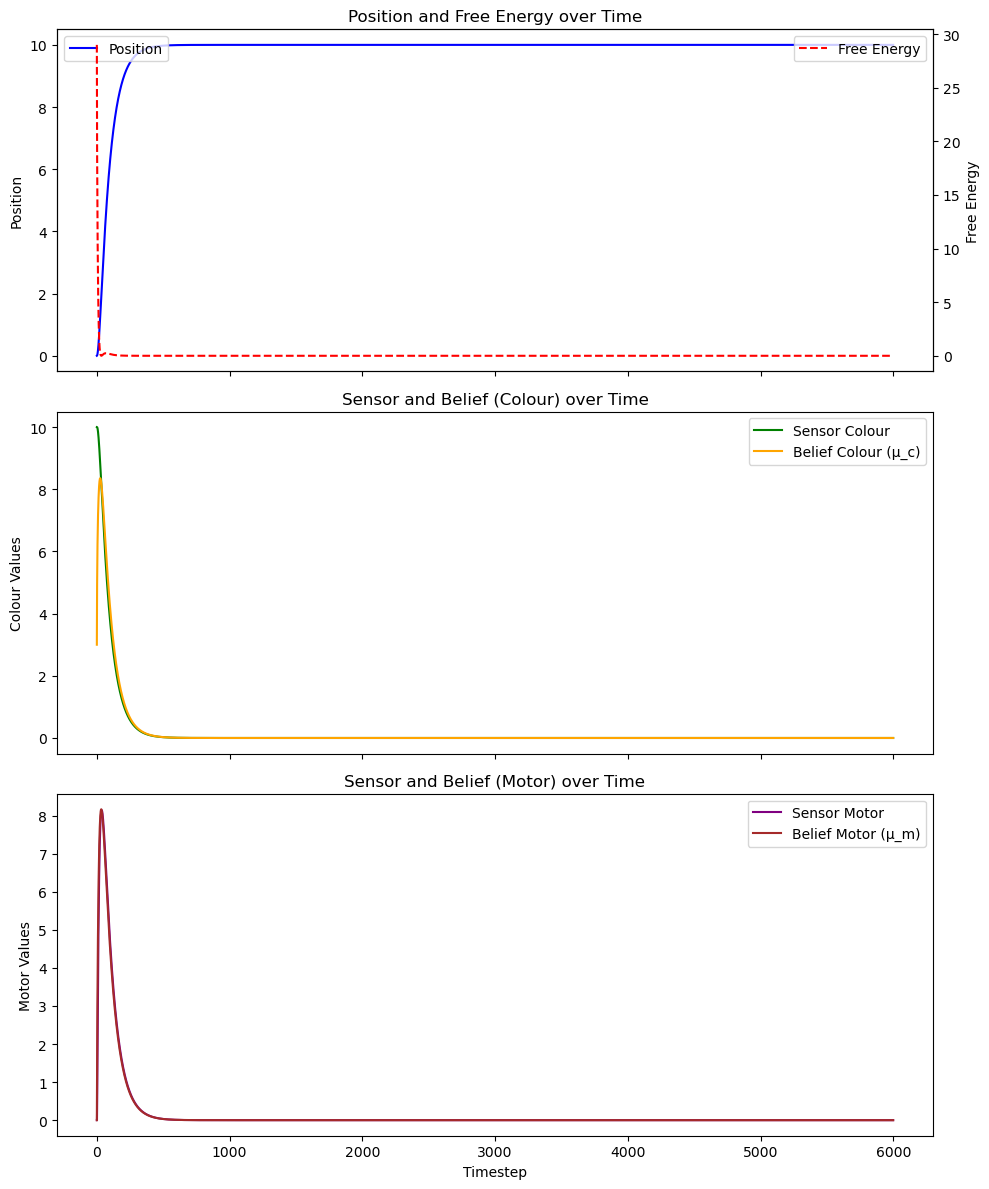

---------------------------------------------------------------------------------------------------------------------
Line plots for robot with periodic c update: cos(x) + 1.1 and for standard case


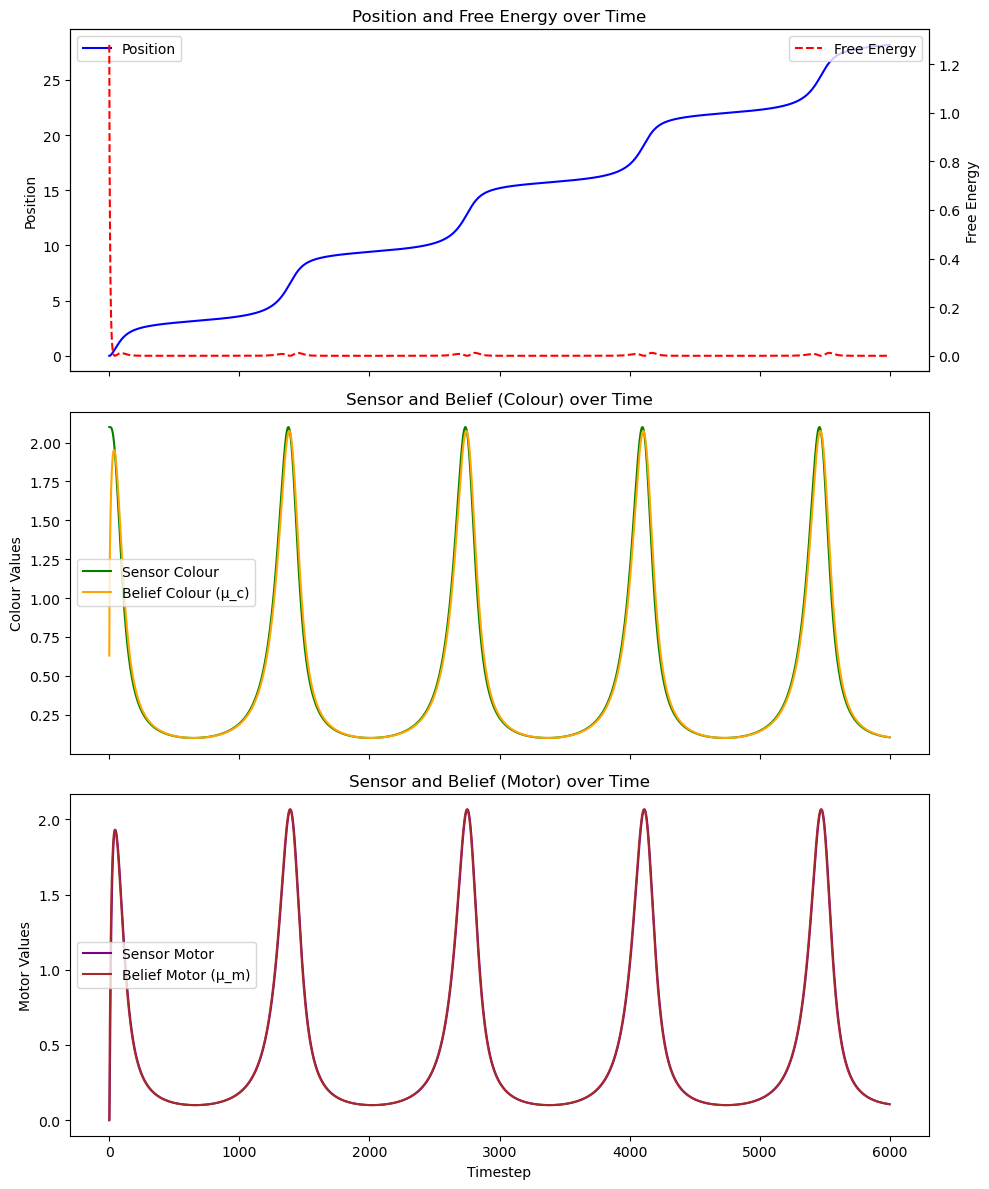

---------------------------------------------------------------------------------------------------------------------


In [92]:
print("---------------------------------------------------------------------------------------------------------------------")
print("Line plots for robot with static c = 1 and for standard case")
robot1.line_plot()
print("---------------------------------------------------------------------------------------------------------------------")
print("Line plots for robot with gradient c update: 10 - x and for standard case")
robot2.line_plot()
print("---------------------------------------------------------------------------------------------------------------------")
print("Line plots for robot with periodic c update: cos(x) + 1.1 and for standard case")
robot3.line_plot()
print("---------------------------------------------------------------------------------------------------------------------")

## 3.1 k = 0.3 ; π_zc = 0.0001 π_zm = π_wm = 1 ; the robot does not update its belief for µ_c
### First we see the line plots for static c = 1
Here we can see that the robot is not moving since we are not updating the belief µ_c
Also no other variables are adjusted since the belief µ_c is not updated

### Next for gradient 10 - x
Here we can see that the robot is not moving since we are not updating the belief µ_c
Also no other variables are adjusted since the belief µ_c is not updated

### Then for periodic cos(x) + 1.1
Here we can see that the robot is not moving since we are not updating the belief µ_c
Also no other variables are adjusted since the belief µ_c is not updated


In [93]:
#3.2
robot4 = Robot(π_zc=0.0001, static=True, upd_c=False)
robot5 = Robot(π_zc=0.0001, gradient=True, upd_c=False)
robot6 = Robot(π_zc=0.0001, periodic=True, upd_c=False)
for i in range(6000):
    robot4.step()
    robot5.step()
    robot6.step()


---------------------------------------------------------------------------------------------------------------------
Line plots for robot with static c = 1 and without updating belief of colour


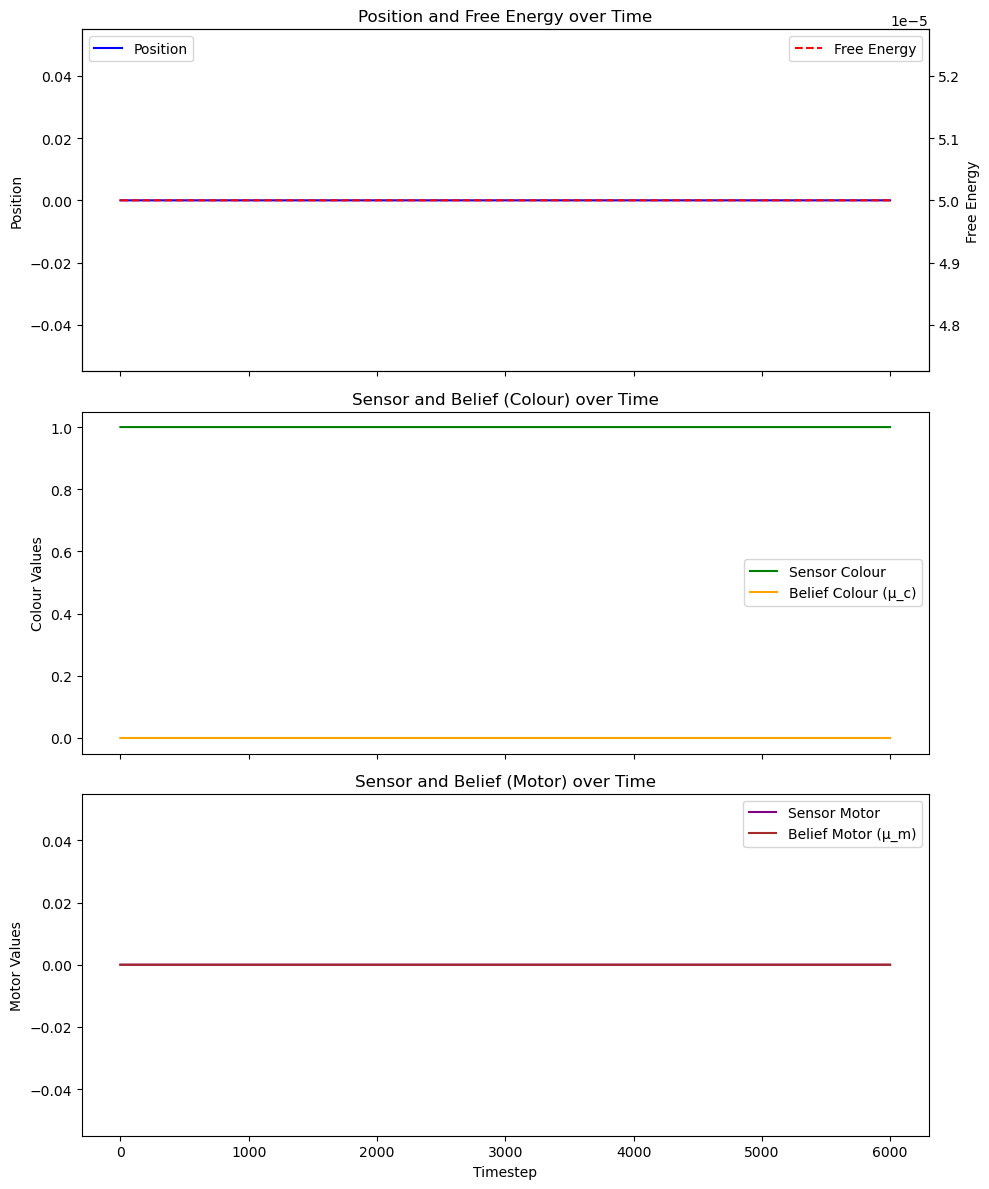

---------------------------------------------------------------------------------------------------------------------
Line plots for robot with gradient c update: 10 - x and without updating belief of colour


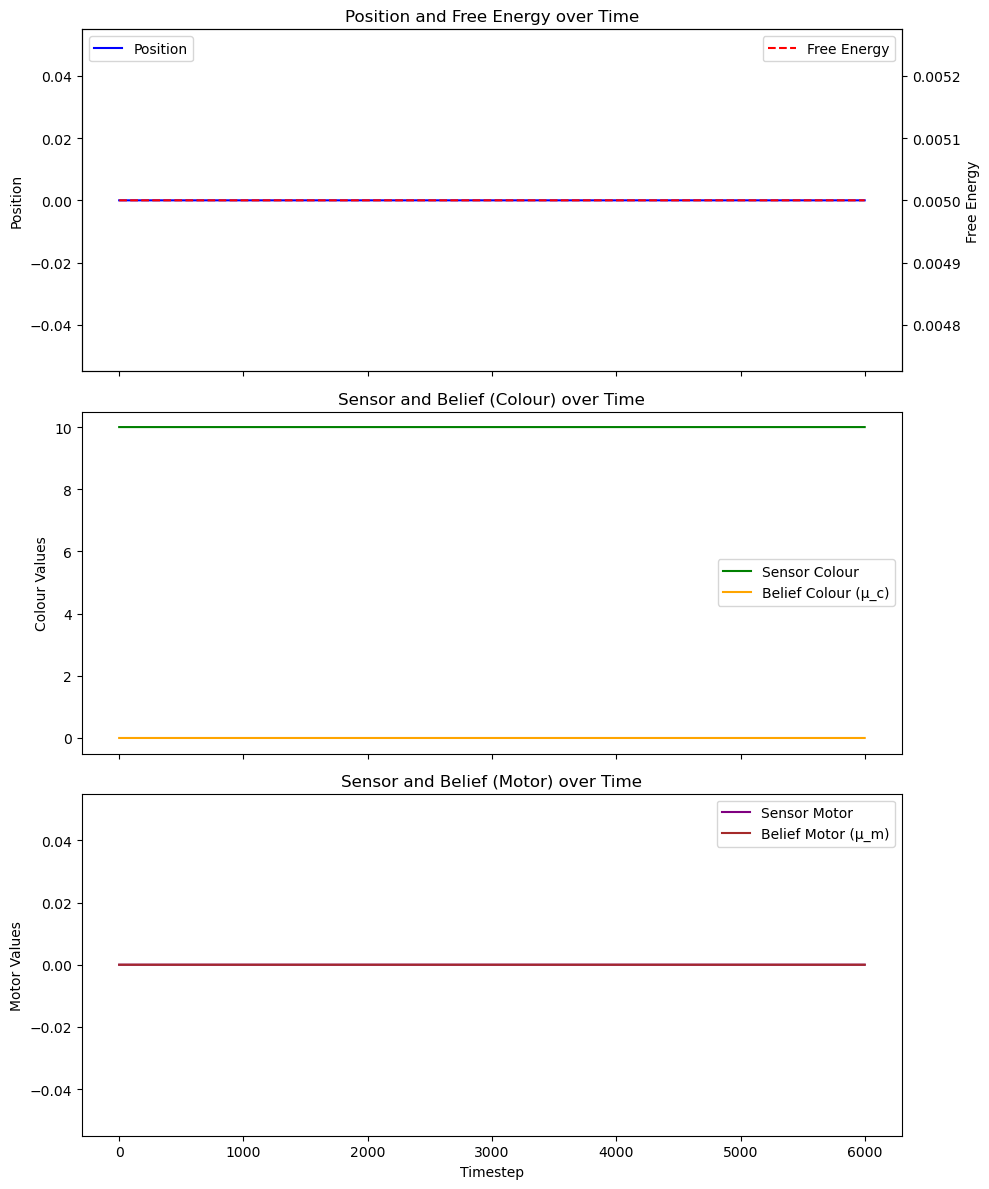

---------------------------------------------------------------------------------------------------------------------
Line plots for robot with periodic c update: cos(x) + 1.1 and without updating belief of colour


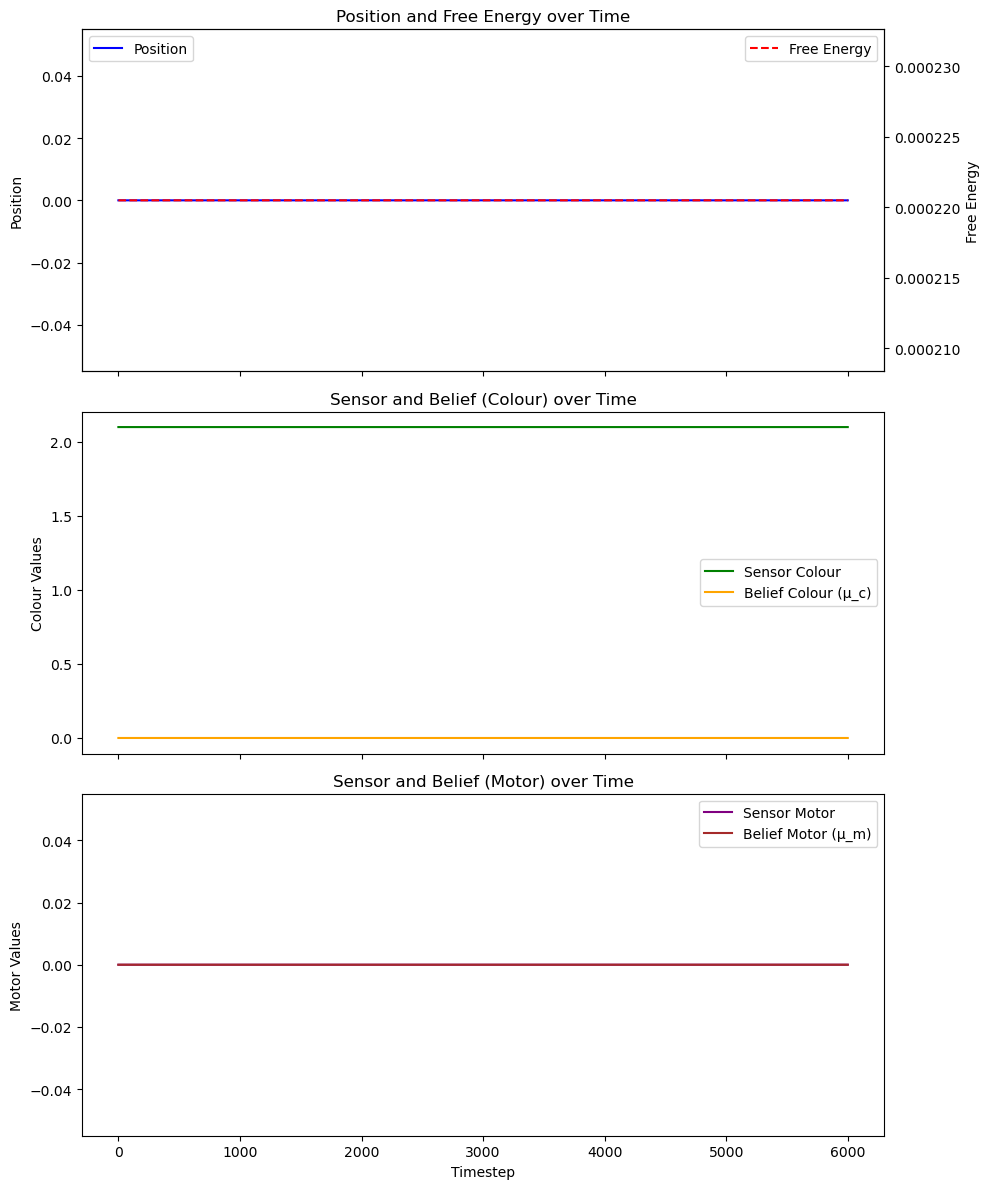

---------------------------------------------------------------------------------------------------------------------


In [94]:
print("---------------------------------------------------------------------------------------------------------------------")
print("Line plots for robot with static c = 1 and without updating belief of colour")
robot4.line_plot()
print("---------------------------------------------------------------------------------------------------------------------")
print("Line plots for robot with gradient c update: 10 - x and without updating belief of colour")
robot5.line_plot()
print("---------------------------------------------------------------------------------------------------------------------")
print("Line plots for robot with periodic c update: cos(x) + 1.1 and without updating belief of colour")
robot6.line_plot()
print("---------------------------------------------------------------------------------------------------------------------")

## 3.1 k = 0.3 ; π_zm = 0.0001 π_zc = π_wm = 1 ; the robot does not update its belief for µ_m
### First we see the line plots for static: c = 1
The robot is not moving since we are not updating the belief for the motor µ_m

The belief of the colour µ_c is still gradually updated at the beginning (first 10 steps) and converges at 0.5 (since then µ_c - s_c = 0.5)

### Next for gradient: c = 10 - x
The robot is not moving since we are not updating the belief for the motor µ_m

The belief of the colour µ_c is still gradually updated at the beginning (first 10 steps) and converges at 5 (since then µ_c - s_c = 5)

Essentially the same as c = 1 because a is not updated so c = 10

### Then for periodic: c = cos(x) + 1.1
The robot is not moving since we are not updating the belief for the motor µ_m

The belief of the colour µ_c is still gradually updated at the beginning (first 10 steps) and converges at 1.05 (since then µ_c - s_c = 1.05)

Essentially the same as c = 1 and c = 10 since cos(0) = 1 so c = 1 + 1.1


In [95]:
#3.3
robot7 = Robot(π_zm=0.0001, static=True, upd_m=False)
robot8 = Robot(π_zm=0.0001, gradient=True, upd_m=False)
robot9 = Robot(π_zm=0.0001, periodic=True, upd_m=False)
for i in range(6000):
    robot7.step()
    robot8.step()
    robot9.step()

---------------------------------------------------------------------------------------------------------------------
Line plots for robot with static c = 1 and without updating belief of motor


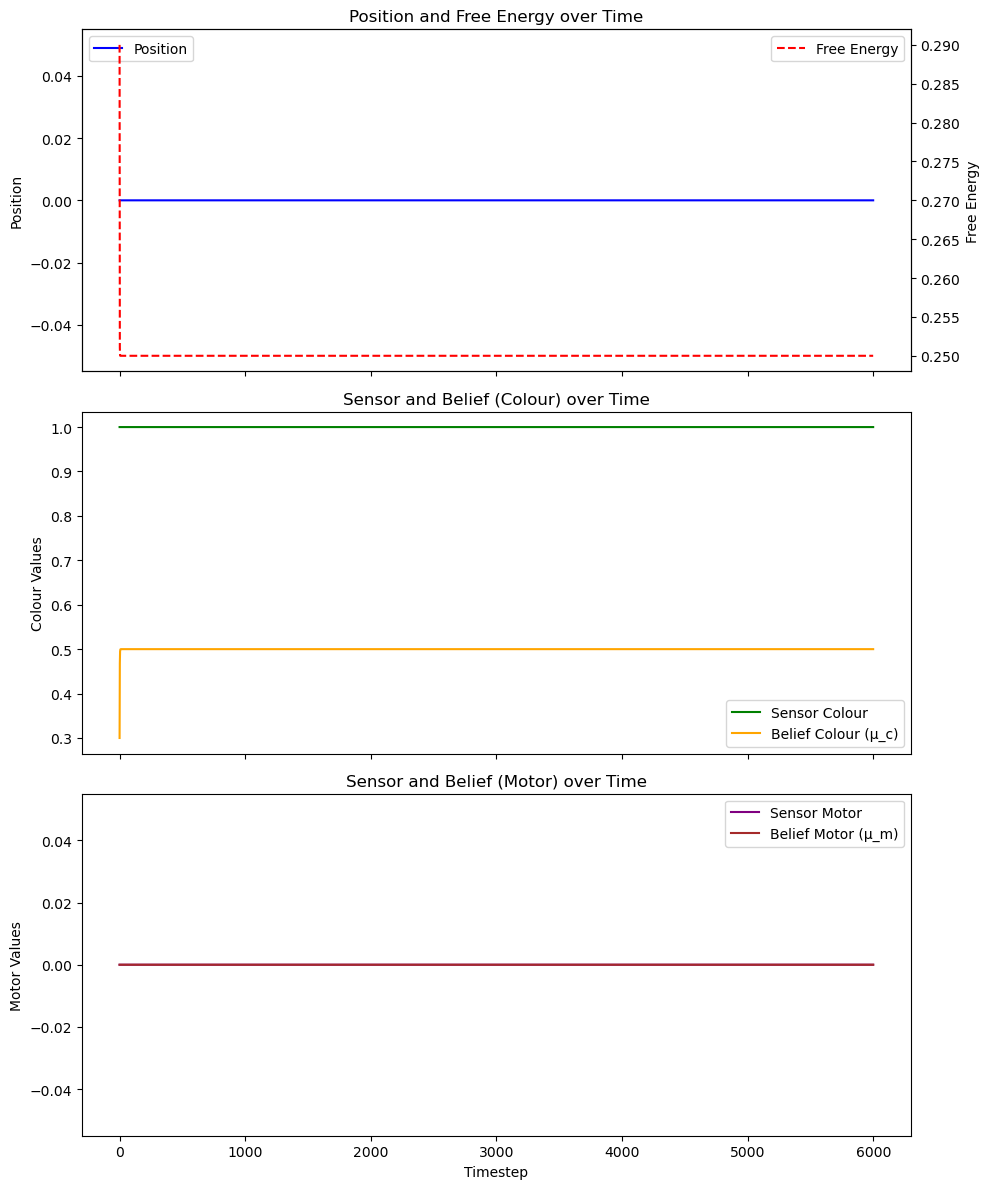

---------------------------------------------------------------------------------------------------------------------
Line plots for robot with gradient c update: 10 - x and without updating belief of motor


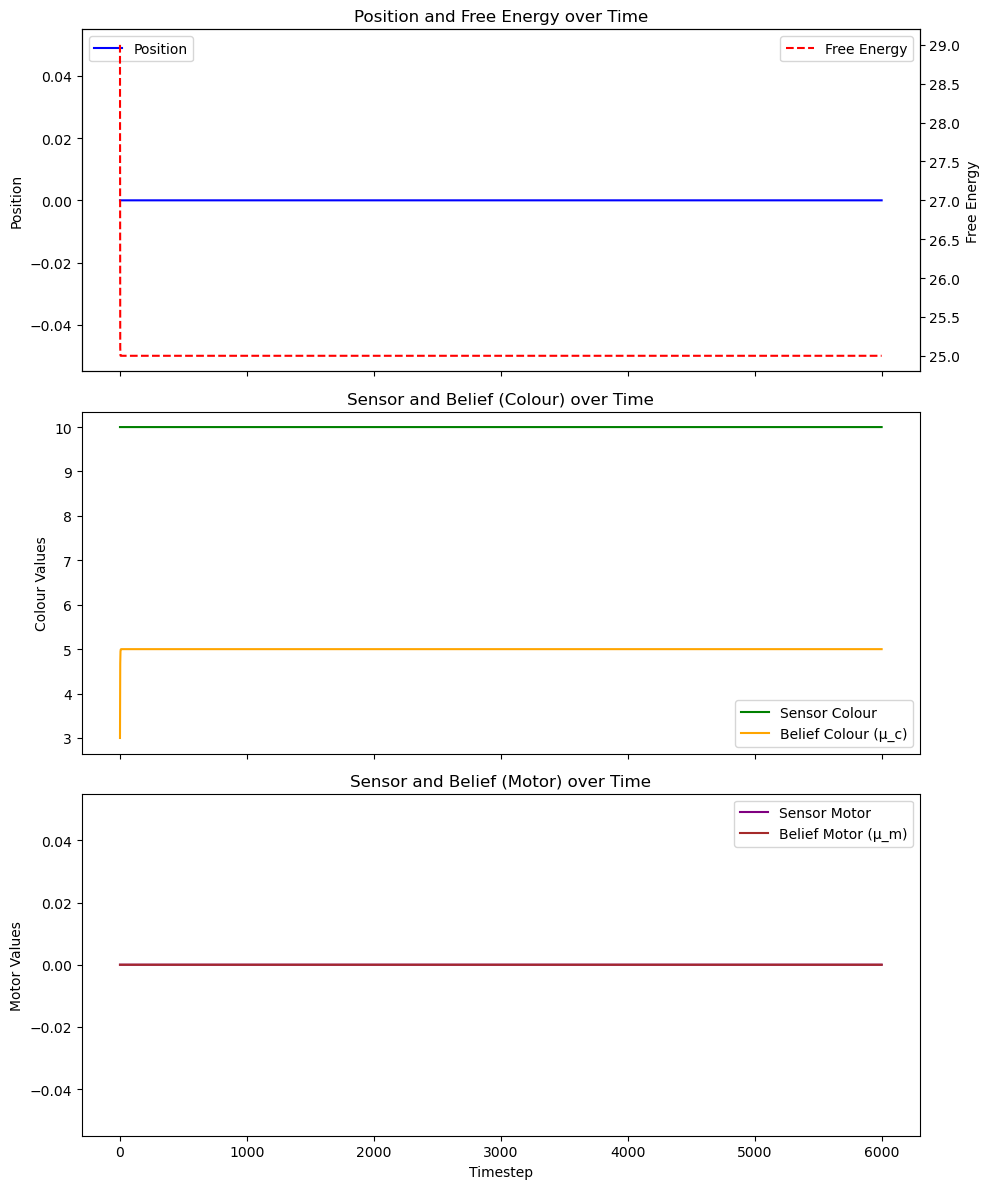

---------------------------------------------------------------------------------------------------------------------
Line plots for robot with periodic c update: cos(x) + 1.1 and without updating belief of motor


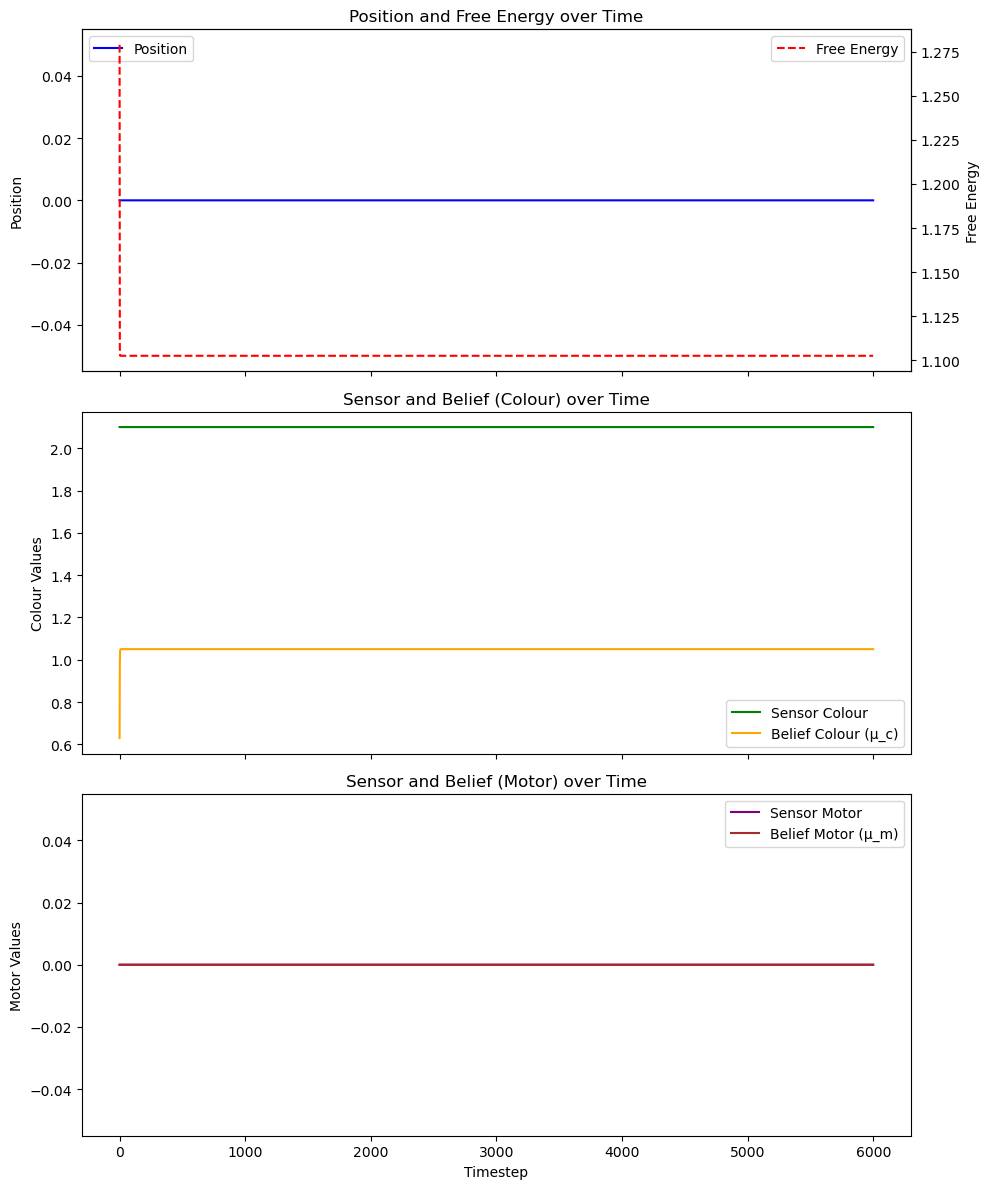

---------------------------------------------------------------------------------------------------------------------


In [96]:
print("---------------------------------------------------------------------------------------------------------------------")
print("Line plots for robot with static c = 1 and without updating belief of motor")
robot7.line_plot()
print("---------------------------------------------------------------------------------------------------------------------")
print("Line plots for robot with gradient c update: 10 - x and without updating belief of motor")
robot8.line_plot()
print("---------------------------------------------------------------------------------------------------------------------")
print("Line plots for robot with periodic c update: cos(x) + 1.1 and without updating belief of motor")
robot9.line_plot()
print("---------------------------------------------------------------------------------------------------------------------")